In [1]:
#change working directory, for moduls of other package
import os
os.chdir(os.path.abspath('../../../../00_src'))

In [2]:
import sys
import time
import copy
import numpy as np
import random
from dotenv import load_dotenv
from pathlib import Path
from agents.agent_ollama import AgentOllama
from environment.environment import SokobanEnvImpl
import environment.util as env_util
import environment.const as env_const
import environment.visualization as env_vis
from knowledge_graph.knowledge_graph import KnowledgeGraph
from langchain_neo4j import Neo4jGraph
from langchain_ollama import ChatOllama
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from typing import List
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
%matplotlib inline

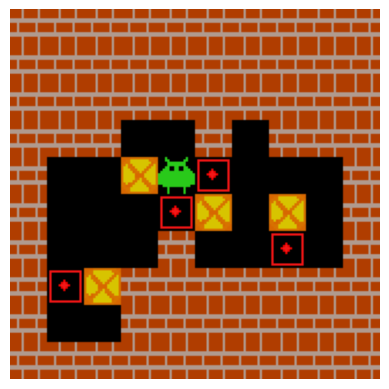

In [3]:
UP, DOWN, LEFT, RIGHT = env_const.UP, env_const.DOWN, env_const.LEFT, env_const.RIGHT
WALL, FLOOR, BOX_TARGET, BOX_ON_TARGET, BOX, PLAYER = env_const.WALL, env_const.FLOOR, env_const.BOX_TARGET, env_const.BOX_ON_TARGET, env_const.BOX, env_const.PLAYER
env = SokobanEnvImpl(max_steps=60, use_default_env=True)
kg = KnowledgeGraph(env)
env_vis.render(env=env, dpi=100)

In [4]:
action_caption_map = {0: "WAIT", UP:"UP", DOWN:"DOWN", LEFT:"LEFT", RIGHT:"RIGHT"}

def create_search_env(env:SokobanEnvImpl, target_box:tuple)->SokobanEnvImpl:
    room_state = copy.deepcopy(env.room_state)
    room_fixed = copy.deepcopy(env.room_fixed)

    for y, row in enumerate(room_state):
        for x, val in enumerate(row):
            if (val == BOX and not (x == target_box[0] and y == target_box[1])) or val == BOX_ON_TARGET:
                room_state[y][x] = WALL
                room_fixed[y][x] = WALL
    return SokobanEnvImpl(fixated_env=(room_fixed,room_state,{}))
                

def find_shortest_paths_to_place_remaining_boxes(env:SokobanEnvImpl) -> list:
    result = []
    for y, row in enumerate(env.room_state):
        for x, val in enumerate(row):
            if val == BOX:
                search_env = create_search_env(env, (x,y))
                path = np.array2string(np.vectorize(action_caption_map.get)(env_util.breadth_first_search(search_env)), max_line_width=sys.maxsize)
                result.append({"caption":"Box [{x},{y}]".format(x=x, y=y), "x":x, "y":y, "shortest_path_to_place":path})
    result_sorted = sorted(result, key=lambda n: len(n['shortest_path_to_place']))
    return result_sorted

# LangGraph

In [5]:
class InputState(TypedDict):
    ignore: None


class OverallState(TypedDict):
    selection_id: int
    selection_trajectory: List[int]
    reward: float
    done: bool
    sim_value: float


class OutputState(TypedDict):
    reward: float
    done: bool

In [6]:
def selection(state: InputState) -> OverallState:
    records, summary, keys =  kg.client.read("""
                            MATCH (p:Path)
                            WHERE p.done = false AND size([ (p)-[:MOVE]->(x) | x ]) < size(p.possible_actions)
                            RETURN p
                            ORDER BY p.value DESC
                            LIMIT 1
                            """)
    if len(records) != 1:
          raise Exception("No further paths can be examined.")
    return {"selection_id":records[0]["p"]["id"], "selection_trajectory":records[0]["p"]["trajectory"]}

In [7]:
caption_action_map = {"UP":UP, "DOWN":DOWN, "LEFT":LEFT, "RIGHT":RIGHT}

def doStep(action:int) -> bool:
    observation, reward_last, done, info = env.step(action)
    kg.step(action, reward_last, done)
    return observation, reward_last, done, info

agent_player = AgentOllama("qwen3:32b",
[("system","You are a player which tries to solve a Sokoban game. Keep the reasoning short. Respond only with a single action out of ['UP', 'DOWN', 'LEFT', 'RIGHT'].",),
("human",("""Use the following results retrieved from a database to provide the next action for the Sokoban game.
Enviroment: {enviorment}
Shortest paths to place remaining boxes: {shortest_paths_to_place_remaining_boxes}
Attempted Actions: {attempted_actions}
Posstible Actions: {possible_actions}
Action: """),),],
extract_reasoning=True)

agent_player.write_log("../03_resource/09_LLM_KG/03_monte_carlo_search_tree/output/08_attempt_agent_player.log", clear_log_path=True)

def expansion(state: OverallState) -> OverallState:
     id = state.get("selection_id")
     trajectory = state.get("selection_trajectory")
     env.set_state(trajectory)
     kg.set_state(trajectory)

     #Enviroment
     enviroment, summary, keys =  kg.client.read("""
                                                 MATCH (e) 
                                                 WHERE NOT e:Path AND NOT e:Action
                                                 RETURN 
                                                  CASE 
                                                    WHEN e.has_box_target IS NOT NULL THEN {caption: e.caption, x: e.x, y: e.y, has_box_target: e.has_box_target}
                                                    WHEN e.is_on_target IS NOT NULL THEN {caption: e.caption + ' [' + toString(e.x) + ',' + toString(e.y) + ']', x: e.x, y: e.y, is_on_target: e.is_on_target}
                                                    ELSE {caption: e.caption, x: e.x, y: e.y}
                                                END AS environment""")
     
     # Shortest Paths to place remaining boxes
     shortest_paths_to_place_remaining_boxes = find_shortest_paths_to_place_remaining_boxes(env)
     
     # Attempted actions
     attempted_actions, summary, keys =  kg.client.read("""
                            MATCH (p:Path {{id: {id}}})-[m:MOVE]->(c:Path)
                            MATCH (a:Action)
                            WHERE m.id = a.id
                            RETURN {{caption: a.caption, reward: p.reward-c.reward}} AS attempted_actions
                            """.format(id=id))

     # Unexplored actions
     records, summary, keys =  kg.client.read("""
                            MATCH (a:Action)
                            WHERE NOT EXISTS {{
                              MATCH (p:Path {{id: {id}}})-[m:MOVE]->(c:Path)
                              WHERE m.id = a.id
                            }}
                            RETURN a.caption AS possible_actions
                            """.format(id=id))
     possible_actions = [caption_action_map.get(record["possible_actions"].upper()) for record in records]
     
     # agent
     next_step = agent_player.invoke(
        {"enviorment": enviroment,
         "shortest_paths_to_place_remaining_boxes": shortest_paths_to_place_remaining_boxes,
         "attempted_actions": attempted_actions,
         "possible_actions": records}
     )
     
     # evaluate action
     next_action = 0 # default do nothing
     for action_id in caption_action_map.keys():
        if action_id in next_step:
            next_action = caption_action_map.get(action_id)
    
     # fail safe
     if next_action not in possible_actions:
         next_action = random.choice(possible_actions)

     observation, reward_last, done, info = doStep(next_action)

     return {"reward":reward_last, "done":done}

In [8]:
def eval_state()->float:
    #todo: base on simulation
    optimal = env_util.breadth_first_search(env)
    state_value = 0
    if optimal != None:
        state_value = (60-len(optimal))/60
    return state_value

def simulation(state: OverallState) -> OverallState:
    sim_value = eval_state()
    return {"reward":state.get("reward"), "done":state.get("done"), "sim_value":sim_value}

In [9]:
def backprop(state: OverallState) -> OverallState:
    kg.backprop(state.get("sim_value"))
    return {"reward":state.get("reward"), "done":state.get("done")}

In [10]:
langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(selection)
langgraph.add_node(expansion)
langgraph.add_node(simulation)
langgraph.add_node(backprop)

langgraph.add_edge(START, "selection")
langgraph.add_edge("selection", "expansion")
langgraph.add_edge("expansion", "simulation")
langgraph.add_edge("simulation", "backprop")
langgraph.add_edge("backprop", END)

langgraph = langgraph.compile()

In [11]:
kg.backprop(eval_state())

### Run

In [12]:
start_time = time.time()
while True:
    result = langgraph.invoke({}, {"recursion_limit": 200})
    if result.get("reward") > 5:
        break

env.reset()
optimal = env_util.breadth_first_search(env)
end_time_min = (time.time() - start_time) / 60
path_nodes, summary, keys = kg.client.read("""MATCH (p:Path) RETURN p""")
records, summary, keys = kg.client.read("""MATCH (p:Path) WHERE p.done RETURN p """)
trajectory = records[0]["p"]["trajectory"]
print("solved \t optimal {optimal} \t solution {solution} \t path nodes {nodes} \t {time} m \t "
      .format(optimal=len(optimal), solution=len(trajectory), nodes=len(path_nodes), time=end_time_min))
env_vis.animate(env=env, path=trajectory, save_ani="../03_resource/09_LLM_KG/03_monte_carlo_search_tree/output/08_attempt.gif", dpi=300)

solved 	 optimal 30 	 solution 30 	 path nodes 49 	 24.634623169898987 m 	 
